# Print all structures for some cells

Specify a cell ID and what structures you want, and generate random draws of localization for each structure.

Concat all and print.  Plot some real structures for comparison.

In [2]:
import json
from pathlib import Path
import os

from tqdm import tqdm

import pandas as pd
import numpy as np
import torch

import PIL
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

import integrated_cell
from integrated_cell import model_utils, utils
from integrated_cell.utils.plots import tensor2im, imshow

## Prep

### Gpus

In [3]:
gpu_ids = [1]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

torch.cuda.empty_cache()

### Load models

In [4]:
REF_MODEL_KWARGS = dict(
    model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04',
    parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/',
    suffix = '_94544'
)

TARG_MODEL_KWARGS = dict(
   parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/',
    model_dir = "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/",
    suffix = '_93300'

)

In [5]:
networks_ref, dp_ref, args_ref = utils.load_network_from_dir(
    REF_MODEL_KWARGS["model_dir"],
    REF_MODEL_KWARGS["parent_dir"],
    suffix=REF_MODEL_KWARGS["suffix"]
)

ref_enc = networks_ref['enc']
ref_dec = networks_ref['dec']

networks_targ, dp_target, args_target = utils.load_network_from_dir(
    TARG_MODEL_KWARGS["model_dir"],
    TARG_MODEL_KWARGS["parent_dir"],
    suffix=TARG_MODEL_KWARGS["suffix"]
)
    
target_enc = networks_targ['enc']
target_dec = networks_targ['dec']

/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:75: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/enc_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/dec_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/enc_93300.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/dec_93300.pth


### Set results dir

In [6]:
RESULTS_DIR = '/allen/aics/modeling/rorydm/results/integrated_cell/print_all_structures/'
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    
print("Results dir: {}".format(RESULTS_DIR))

Results dir: /allen/aics/modeling/rorydm/results/integrated_cell/print_all_structures/


### Helper function for saving images

In [7]:
from aicsimageio.writers import OmeTiffWriter

def im_write(im, path):
    im = im.cpu().detach().numpy().transpose(3,0,1,2)
    
    with OmeTiffWriter(path, overwrite_file=True) as writer:
        writer.save(im)

### Set up the autoencoder

In [8]:
from integrated_cell.networks.ref_target_autoencoder import Autoencoder

mode = 'test'
dp = dp_target
u_classes, class_inds = np.unique(dp.get_classes(np.arange(0, dp.get_n_dat(mode)), mode), return_inverse=True)
u_class_names = dp.label_names[u_classes]

ae = Autoencoder(ref_enc, ref_dec, target_enc, target_dec)
ae.train(False)
ae = ae.cuda()

## main settings

In [298]:
N_EXAMPLES_PER_STRUCTURE = 3
BATCH_SIZE=3

STRUCTURES_TO_GEN = [
    'Actin filaments',
    'Actomyosin bundles',
    'Adherens junctions',
#     'Centrosome',
    'Desmosomes',
    'Endoplasmic reticulum',
    'Endosomes',
    'Gap junctions',
    'Golgi',
    'Lysosome',
    'Matrix adhesions',
    'Microtubules',
    'Mitochondria',
    'Nuclear envelope',
    'Nucleolus (Dense Fibrillar Component)',
    'Nucleolus (Granular Component)',
    'Peroxisomes',
    'Plasma membrane',
    'Tight junctions'
]

structure_to_gen_ids = [np.where(u_class_names == structure)[0].item() for structure in STRUCTURES_TO_GEN]
structure_to_gen_ids = [torch.tensor([x]) for x in structure_to_gen_ids]

### find the images we need

In [299]:
# pick this based on pca location or whatever
MY_CELL_ID = np.random.choice(dp.data['test']['CellId'])
MY_CELL_ID

79417

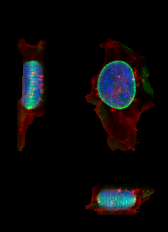

In [300]:
proj_path = Path(dp.csv_data[dp.csv_data["CellId"] == MY_CELL_ID]["save_reg_path_flat_proj"].item())
Image.open(proj_path)

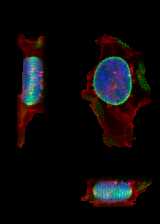

In [301]:
# grab metadata
cell_metadata = dp.csv_data[dp.csv_data.CellId == MY_CELL_ID].drop(columns=["level_0", "Unnamed: 0", "index"])

# search for which split this id is in
splits = {k for k,v in dp.data.items() if MY_CELL_ID in v["CellId"]}
assert len(splits) == 1
split = splits.pop()

# find the index in the split
index_in_split = np.where(dp.data[split]["CellId"] == MY_CELL_ID)[0]
assert len(index_in_split) == 1
index_in_split = index_in_split[0]

# grab the sampled image
gfp_img, struct_ind, ref_img = dp.get_sample(train_or_test=split, inds=[index_in_split])

# make the one-hot encoding
label_onehot = utils.index_to_onehot(struct_ind, len(u_classes)).cuda()

# move ref image to gpu
ref = ref_img.cuda()

# plot sanity check
rgb_img = torch.stack([ref_img[:,0,...], gfp_img[:,0,...], ref_img[:,1,...]], dim=1)
Image.fromarray(
    np.uint8(
        255*tensor2im(
            rgb_img,
            color_transform = np.array(
                [
                    [1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]
                ]
            ).T
        )
    )
)

## loop over structs to generate and save images

In [302]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# TODO: loop over cellid

In [584]:
image_dir = Path(RESULTS_DIR) / "images"
image_dir.mkdir(parents=True, exist_ok=True)

df = pd.DataFrame()

with tqdm(total=N_EXAMPLES_PER_STRUCTURE*len(STRUCTURES_TO_GEN)) as pbar:
    for structure, struct_ind in zip(STRUCTURES_TO_GEN, structure_to_gen_ids):

        pbar.set_description(f"Processing {structure}")
        
        # tmp df for structure info
        df_tmp = cell_metadata[["CellId"]].copy()
        df_tmp[f"GeneratedStructureName"] = structure
        df_tmp[f"GeneratedStructureInstance"] = -1
        df_tmp[f"GeneratedStructuePath"] = ""
        df_tmp = pd.concat([df_tmp]*N_EXAMPLES_PER_STRUCTURE).reset_index(drop=True)

        # loop over batches
        for batch in chunks(range(N_EXAMPLES_PER_STRUCTURE), BATCH_SIZE):

            # one hot structure labels to generate, same for whole batch
            labels_gen_batch = utils.index_to_onehot(struct_ind, len(u_classes)).repeat(len(batch),1).cuda()

            # repeat reference structure over batch
            ref_batch = ref.repeat([len(batch), 1, 1, 1, 1])
    
            # generate our gfp samples
            target_gen_batch, _ = ae(target=None, ref=ref_batch, labels=labels_gen_batch)

            # save images
            for b,im_tensor in zip(batch,target_gen_batch):
                struct_safe_name = structure.replace(" ", "_").lower()
                img_path = image_dir / f"generated_gfp_image_struct_{struct_safe_name}_instance_{b}.ome.tiff"
                im_write(im_tensor, img_path)

                df_tmp.at[b, f"GeneratedStructureInstance"] = b
                df_tmp.at[b, f"GeneratedStructuePath"] = img_path

                pbar.update(1)

        df = df.append(df_tmp)

    # merge df with metadata for cell
    df = df.reset_index(drop=True)
    df_out = cell_metadata.merge(df)
    
# save df
df_out.to_csv(Path(RESULTS_DIR) / "generated_structures.csv", index=False)
df_out.shape

Processing Tight junctions: 100%|██████████| 54/54 [00:12<00:00,  4.29it/s]                      


(54, 81)

### Load tiffs from all generated structures for this cell

In [585]:
from aicsimageio import AICSImage

df_cell = df_out[df_out.CellId == MY_CELL_ID]

ims = {}
for struct in df_cell.GeneratedStructureName.unique():
    ims[struct] = {}
    for i,row in df_cell[df_cell.GeneratedStructureName == struct].iterrows():
        ims[struct][row.GeneratedStructureInstance] = AICSImage(
            row.GeneratedStructuePath
        ).get_image_data("TCYXZ")

### make grid of projected structures to print

In [610]:
from integrated_cell.utils.plots import tensor2im, imshow
from PIL import Image

# stack instances and structs
img_grid_data = np.vstack([
    np.hstack([
        tensor2im(
            torch.from_numpy(img),
            scale_channels=False,
            scale_global=False,
            color_transform=[[1,1,0]]
        )
        for i,img in instances.items()
    ])
    for struct, instances in ims.items()
])

# make image
img_grid_data = np.clip(img_grid_data, 0, np.quantile(img_grid_data, q=0.999))
img_grid_data = img_grid_data/img_grid_data.max()
img_grid = Image.fromarray(np.uint8(img_grid_data*255))

# draw labels
font_color="white"
font=ImageFont.truetype('/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', 16)
for i,struct in enumerate(ims.keys()):
    draw = ImageDraw.Draw(img_grid)
    draw.text((16, 8 + i*(len(img_grid_data)/len(ims.keys()))), struct, font=font, fill=font_color)
    
# too long to fit on a page so split into two images
split_point = len(ims.keys())//2 * len(img_grid_data)//len(ims.keys())
img_grid_1 = Image.fromarray(np.array(img_grid)[:split_point])
img_grid_2 = Image.fromarray(np.array(img_grid)[split_point:])

# save
img_grid_1.save(Path(RESULTS_DIR) / f"cell_{MY_CELL_ID}_image_gen_structure_grid_first_half.png")
img_grid_2.save(Path(RESULTS_DIR) / f"cell_{MY_CELL_ID}_image_gen_structure_grid_second_half.png")

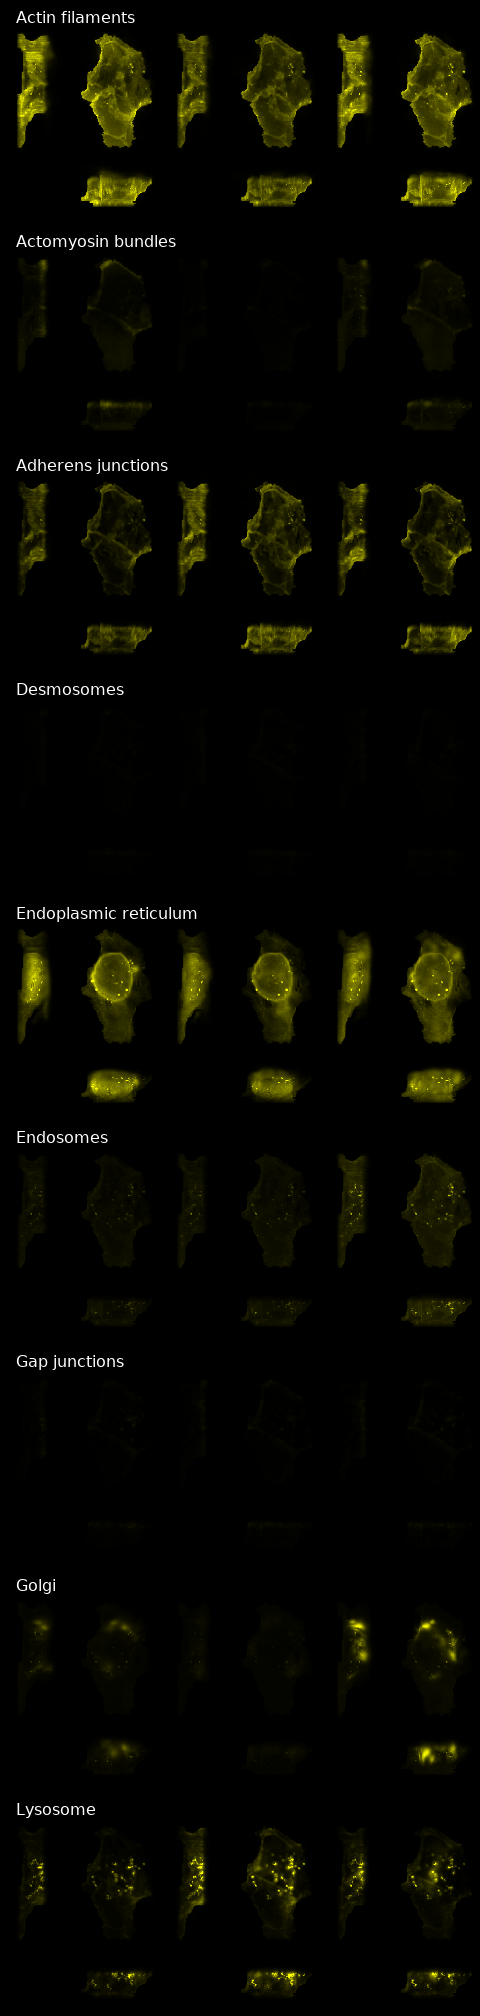

In [611]:
img_grid_1

## make grids of real images

In [386]:
N_real_cells_per_struct = 3

In [387]:
df_test = dp.csv_data.loc[dp.data['test']['inds'], :]

real_cell_ids = {struct:set() for struct in STRUCTURES_TO_GEN}

for struct in STRUCTURES_TO_GEN:
    while len(real_cell_ids[struct]) < N_real_cells_per_struct:
        real_cell_ids[struct].add(df_test[df_test.StructureDisplayName == struct].CellId.sample().item())

In [388]:
real_ims = {}
for struct, cellids in real_cell_ids.items():
    real_ims[struct] = {}
    for cellid in cellids:
        row = df_test[(df_test.CellId==cellid) & (df_test.StructureDisplayName == struct)].squeeze()
        
        mask = AICSImage(
            Path(row.save_dir) / Path(row.save_reg_path).name
        ).get_image_data("STYXZ", C=1)
        
        mask = mask/mask.max()
        
        gfp = AICSImage(
            Path(row.save_dir) / Path(row.save_reg_path).name
        ).get_image_data("STYXZ", C=4)
        
        real_ims[struct][cellid] = gfp*mask

In [389]:
real_img_grid_data.shape

(4176, 840, 3)

In [614]:
from integrated_cell.utils.plots import tensor2im, imshow
from PIL import Image

# stack instances and structs
real_img_grid_data = np.vstack([
    np.hstack([
        tensor2im(
            torch.from_numpy(img),
            scale_channels=False,
            scale_global=False,
            color_transform=[[1,1,0]]
        )
        for i,img in instances.items()
    ])
    for struct, instances in real_ims.items()
])

# make image
real_img_grid_data = np.clip(real_img_grid_data, 0, np.quantile(real_img_grid_data, q=0.999))
real_img_grid_data = real_img_grid_data/real_img_grid_data.max()
real_img_grid = Image.fromarray(np.uint8(real_img_grid_data*255))

# draw labels
font_color="white"
font=ImageFont.truetype('/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', 16)
for i,struct in enumerate(real_ims.keys()):
    draw = ImageDraw.Draw(real_img_grid)
    draw.text((16, 8 + i*(len(real_img_grid_data)/len(real_ims.keys()))), struct, font=font, fill=font_color)
    
# too long to fit on a page so split into two images
real_split_point = len(real_ims.keys())//2 * len(real_img_grid_data)//len(real_ims.keys())
real_img_grid_1 = Image.fromarray(np.array(real_img_grid)[:real_split_point])
real_img_grid_2 = Image.fromarray(np.array(real_img_grid)[real_split_point:])

# save
real_img_grid_1.save(Path(RESULTS_DIR) / f"real_structure_images_grid_first_half.png")
real_img_grid_2.save(Path(RESULTS_DIR) / f"real_structure_images_grid_second_half.png")

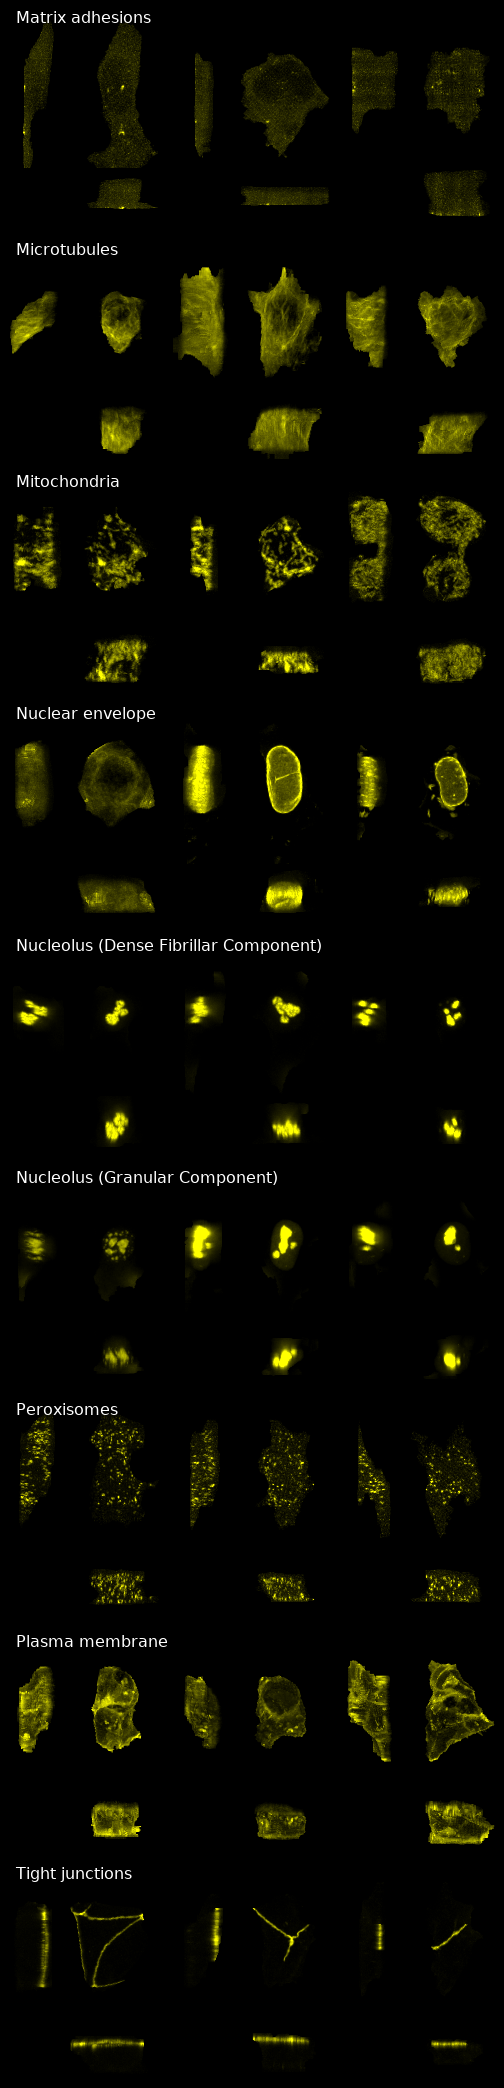

In [616]:
real_img_grid_2